# Machine Learning

Now, onto the fun stuff! Let's get our DataFrames again:

In [1]:
# import things
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Posts and responses all together, with known genders
This dataframe will be used to predict gender, regardless of whether they were the poster or responder.

In [2]:
all_posts_responses = pd.read_pickle("all_posts_responses.pkl")
all_posts_responses.head()

,gender,text,text_length,avg_slen,hedges,source
0,M,Roses are red...and so is Texas. Let's keep it...,23,7.666667,0,fb_congress_post
1,M,"In Texas, we honor our military heroes. #Chris...",11,5.500000,0,fb_congress_post
2,M,President Trump has hit the ground running. As...,27,13.500000,0,fb_congress_post
3,M,"Since its inception, Obamacare has been an abs...",28,9.333333,0,fb_congress_post
4,M,And the repeal process begins...,6,6.000000,0,fb_congress_post


In [3]:
# gender distribution
all_posts_responses.gender.value_counts()

M    120992
W     80292
Name: gender, dtype: int64

In [4]:
# group by gender
all_posts_responses.groupby('gender')['text_length', 'avg_slen', 'hedges'].mean()

,text_length,avg_slen,hedges
gender,,,
M,33.14815,12.256777,0.056714
W,34.58824,12.208115,0.043217


All of these stats are very similar, regardless of gender (even the hedges, which I predicted would be more prominent in female posters). This makes me believe that simply looking at text would be our best bet here.

## Responses to posts, genders visible
This dataframe will be used to predict gender of poster and responder, based on responder's reaction.

In [5]:
gender_visible_df = pd.read_pickle("gender_visible_df.pkl")
gender_visible_df.head()

,op_id,op_gender,responder_id,responder_gender,post_text,response_text,source,post_tokens,response_tokens,post_length,response_length,post_avg_slen,response_avg_slen,post_hedges,response_hedges
0,102,W,1196122,M,Thanks for the follow! I followed back :) I ...,One day at a time! =],fitocracy,"[Thanks, for, the, follow, !, I, followed, bac...","[One, day, at, a, time, !, =, ]]",25,8,12.5,4.000000,0,0
1,104,W,5867,W,I've decided I have this crazy goal of running...,Crazy is synonymous with awesome in this case.,fitocracy,"[I, 've, decided, I, have, this, crazy, goal, ...","[Crazy, is, synonymous, with, awesome, in, thi...",13,9,13.0,9.000000,0,0
2,104,W,1635,M,"Umm, yeah, so those are assisted pull-ups. Bef...",You can enter assisted pullups. Select pullups...,fitocracy,"[Umm, ,, yeah, ,, so, those, are, assisted, pu...","[You, can, enter, assisted, pullups, ., Select...",19,57,9.5,11.400000,0,0
3,117,M,8520,W,dam gurl lookin mad tone in dat pp holla bb,"Mirin 3% bodyfat? Yeah, you are.",fitocracy,"[dam, gurl, lookin, mad, tone, in, dat, pp, ho...","[Mirin, 3, %, bodyfat, ?, Yeah, ,, you, are, .]",10,10,10.0,5.000000,0,0
4,117,M,29126,M,What's up there bear mode?,"Hey! I just started a new job, so things are s...",fitocracy,"[What, 's, up, there, bear, mode, ?]","[Hey, !, I, just, started, a, new, job, ,, so,...",7,26,7.0,8.666667,0,0


In [6]:
gender_visible_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396766 entries, 0 to 396765
Data columns (total 15 columns):
op_id                396766 non-null object
op_gender            396766 non-null object
responder_id         396766 non-null object
responder_gender     396766 non-null object
post_text            396766 non-null object
response_text        396766 non-null object
source               396766 non-null object
post_tokens          396766 non-null object
response_tokens      396766 non-null object
post_length          396766 non-null int64
response_length      396766 non-null int64
post_avg_slen        396766 non-null float64
response_avg_slen    396766 non-null float64
post_hedges          396766 non-null int64
response_hedges      396766 non-null int64
dtypes: float64(2), int64(4), object(9)
memory usage: 45.4+ MB


Everything looks great! Let's recap some basic stats:

In [7]:
# poster gender distribution
gender_visible_df.op_gender.value_counts()

M    237339
W    159427
Name: op_gender, dtype: int64

In [8]:
# responder gender distribution
gender_visible_df.responder_gender.value_counts()

M    217639
W    179127
Name: responder_gender, dtype: int64

In [9]:
gender_visible_df.groupby(['source','op_gender','responder_gender'])['post_length','response_length',
                                                                     'post_avg_slen','response_avg_slen'].mean()

post_length  response_length  \
source    op_gender responder_gender                                 
fitocracy M         M                   19.023550        16.612086   
                    W                   15.503597        31.527746   
          W         M                   19.160420        15.814585   
                    W                   18.134494        40.720844   
reddit    M         M                   48.399651        38.106992   
                    W                   62.564599        48.993869   
          W         M                   55.883847        50.545774   
                    W                   58.729640        47.042140   

                                      post_avg_slen  response_avg_slen  
source    op_gender responder_gender                                    
fitocracy M         M                      9.677136           8.384321  
                    W                      8.910398          11.419609  
          W         M                      9.066472           7.888464  
                    W                      9.586728          13.561374  
reddit    M         M                     13.993324          12.982770  
                    W                     15.221700          13.782006  
          W         M                     14.828193          14.161640  
                    W                     15.947841          14.290182

So Reddit posts seem to be longer overall than posts on Fitocracy. This makes me believe that this may not be such a good statistic to use for machine learning. The more important factor may be the actual content of the text.

In [10]:
# hedges

# male posters with hedges
male_hedges_post = gender_visible_df[(gender_visible_df.op_gender == 'M') & (gender_visible_df.post_hedges != 0)]
# male responders with hedges
male_hedges_response = gender_visible_df[(gender_visible_df.responder_gender == 'M') & (gender_visible_df.response_hedges != 0)]

# female posters with hedges
female_hedges_post = gender_visible_df[(gender_visible_df.op_gender == 'W') & (gender_visible_df.post_hedges != 0)]
# female responders with hedges
female_hedges_response = gender_visible_df[(gender_visible_df.responder_gender == 'W') & (gender_visible_df.response_hedges != 0)]

print('percentage male posters with hedges:',
      len(male_hedges_post.index) / gender_visible_df.op_gender.value_counts()['M'])

print('percentage female posters with hedges:',
      len(female_hedges_post.index) / gender_visible_df.op_gender.value_counts()['W'])

print('percentage male responders with hedges:',
      len(male_hedges_response.index) / gender_visible_df.responder_gender.value_counts()['M'])

print('percentage female responders with hedges:',
      len(female_hedges_response.index) / gender_visible_df.responder_gender.value_counts()['W'])

percentage male posters with hedges: 0.05012239876295088
percentage female posters with hedges: 0.03971723735628219
percentage male responders with hedges: 0.053712799636094634
percentage female responders with hedges: 0.036292686194711016


This is actually the opposite trend that I wanted to see. It was my belief coming in that female posters/responders would use more hedges, but that is in fact not the case. But Reddit was actually skewed in the direction I wanted! What does just Reddit data look like?

In [11]:
reddit = gender_visible_df[gender_visible_df.source == 'reddit']

# male posters with hedges
male_hedges_post = reddit[(reddit.op_gender == 'M') & (reddit.post_hedges != 0)]
# male responders with hedges
male_hedges_response = reddit[(reddit.responder_gender == 'M') & (reddit.response_hedges != 0)]

# female posters with hedges
female_hedges_post = reddit[(reddit.op_gender == 'W') & (reddit.post_hedges != 0)]
# female responders with hedges
female_hedges_response = reddit[(reddit.responder_gender == 'W') & (reddit.response_hedges != 0)]

print('percentage male posters with hedges:',
      len(male_hedges_post.index) / reddit.op_gender.value_counts()['M'])

print('percentage female posters with hedges:',
      len(female_hedges_post.index) / reddit.op_gender.value_counts()['W'])

print('percentage male responders with hedges:',
      len(male_hedges_response.index) / reddit.responder_gender.value_counts()['M'])

print('percentage female responders with hedges:',
      len(female_hedges_response.index) / reddit.responder_gender.value_counts()['W'])

percentage male posters with hedges: 0.11949497649408028
percentage female posters with hedges: 0.16261107313738893
percentage male responders with hedges: 0.1084285233662827
percentage female responders with hedges: 0.15475588160890463


So this looks how I'd expect. It seems to be the Fitocracy data that is messing with my hypothesis. Thus, using the hedge data in machine learning will not work for this combined data set. Maybe we should just focus on the text.

## Solidifying ML plan

So what do I actually want to be able to predict?

1. Simply the gender of the poster/responder, based on the text alone (ignoring whether they are the poster or responder).
2. A more interesting and complicated topic would be analyzing the responder's text and predicting both their own gender and the original poster's gender. This way, we could see if different genders really do respond differently given who they are responding to. Let's make a dataframe that would fit this purpose:

In [12]:
# getting just the columns we want
responder_df = gender_visible_df[['op_gender','responder_gender','response_text',
                                  'response_tokens','response_length','response_avg_slen']]

responder_df.head()

,op_gender,responder_gender,response_text,response_tokens,response_length,response_avg_slen
0,W,M,One day at a time! =],"[One, day, at, a, time, !, =, ]]",8,4.000000
1,W,W,Crazy is synonymous with awesome in this case.,"[Crazy, is, synonymous, with, awesome, in, thi...",9,9.000000
2,W,M,You can enter assisted pullups. Select pullups...,"[You, can, enter, assisted, pullups, ., Select...",57,11.400000
3,M,W,"Mirin 3% bodyfat? Yeah, you are.","[Mirin, 3, %, bodyfat, ?, Yeah, ,, you, are, .]",10,5.000000
4,M,M,"Hey! I just started a new job, so things are s...","[Hey, !, I, just, started, a, new, job, ,, so,...",26,8.666667


In [13]:
# let's combine op_gender and responder_gender into one column, because this is what we want to predict
# original poster's gender is first character, responder's gender is second character
responder_df['gender_info'] = responder_df.op_gender + responder_df.responder_gender
responder_df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,op_gender,responder_gender,response_text,response_tokens,response_length,response_avg_slen,gender_info
0,W,M,One day at a time! =],"[One, day, at, a, time, !, =, ]]",8,4.000000,WM
1,W,W,Crazy is synonymous with awesome in this case.,"[Crazy, is, synonymous, with, awesome, in, thi...",9,9.000000,WW
2,W,M,You can enter assisted pullups. Select pullups...,"[You, can, enter, assisted, pullups, ., Select...",57,11.400000,WM
3,M,W,"Mirin 3% bodyfat? Yeah, you are.","[Mirin, 3, %, bodyfat, ?, Yeah, ,, you, are, .]",10,5.000000,MW
4,M,M,"Hey! I just started a new job, so things are s...","[Hey, !, I, just, started, a, new, job, ,, so,...",26,8.666667,MM


In [14]:
# drop the columns (keep op_gender in there for later)
responder_df.drop(labels=['responder_gender'], axis=1, inplace=True)
responder_df.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,op_gender,response_text,response_tokens,response_length,response_avg_slen,gender_info
0,W,One day at a time! =],"[One, day, at, a, time, !, =, ]]",8,4.000000,WM
1,W,Crazy is synonymous with awesome in this case.,"[Crazy, is, synonymous, with, awesome, in, thi...",9,9.000000,WW
2,W,You can enter assisted pullups. Select pullups...,"[You, can, enter, assisted, pullups, ., Select...",57,11.400000,WM
3,M,"Mirin 3% bodyfat? Yeah, you are.","[Mirin, 3, %, bodyfat, ?, Yeah, ,, you, are, .]",10,5.000000,MW
4,M,"Hey! I just started a new job, so things are s...","[Hey, !, I, just, started, a, new, job, ,, so,...",26,8.666667,MM


## Predict gender of poster/responder
Let's start simple! Given our `all_posts_responses` dataframe, can we predict the gender of the poster/responder?

In [15]:
all_posts_responses.head()

,gender,text,text_length,avg_slen,hedges,source
0,M,Roses are red...and so is Texas. Let's keep it...,23,7.666667,0,fb_congress_post
1,M,"In Texas, we honor our military heroes. #Chris...",11,5.500000,0,fb_congress_post
2,M,President Trump has hit the ground running. As...,27,13.500000,0,fb_congress_post
3,M,"Since its inception, Obamacare has been an abs...",28,9.333333,0,fb_congress_post
4,M,And the repeal process begins...,6,6.000000,0,fb_congress_post


In [16]:
all_posts_responses.gender.value_counts(normalize=True)

M    0.601101
W    0.398899
Name: gender, dtype: float64

So our baseline is 60% here.

### Using Naive-Bayes

In [17]:
X = list(all_posts_responses.text)
y = list(all_posts_responses.gender)

# create train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(len(y_train))
print(len(y_test))

161027
40257


In [18]:
# fit to model
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

# this takes way too long - maybe try CRC
#model = make_pipeline(TfidfVectorizer(ngram_range=(1,2), stop_words='english'), SVC(kernel='linear', C=1E3, random_state=0))

# choose own parameters
#model = make_pipeline(TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2)),
                      #MultinomialNB())

# what if we want punctuation? takes longer to use nltk word tokenizer though. is it worth it?
import nltk
model = make_pipeline(TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2), tokenizer=nltk.word_tokenize),
                      MultinomialNB())

In [19]:
# fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

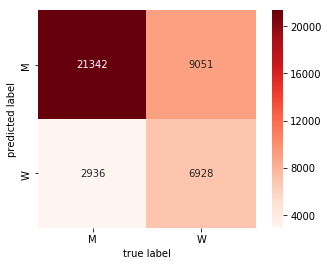

accuracy: 0.7022381200784956


In [20]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score

mat = confusion_matrix(y_test, y_pred)

labels = sorted(set(y_test))

# plot it
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

# save
plt.savefig('images/predict_1gender_cm.png')

# show
plt.show()

print('accuracy:', accuracy_score(y_test, y_pred))

With the built in tokenizer (excluding punctuation), accuracy was around 69.2%. However, above is when I include punctuation with nltk's word tokenizer, and we get an accuracy of 70.2%! Small difference - but still a whole percentage point. And I'm okay (ish) with a 70% accuracy when baseline was 60% - we are at least 10% better than guessing, and this is with the simplest algorithm! So what is going on with punctuation? Does one gender use more than the other? Do they use it differently?

In [21]:
# examine punctuation
print("'!' classified as", model.predict(['!'])[0], 'with probabilities:', model.predict_proba(['!']))
print("'!!' classified as", model.predict(['!!'])[0], 'with probabilities:', model.predict_proba(['!!']))
print("'?' classified as", model.predict(['?'])[0], 'with probabilities:', model.predict_proba(['?']))
print("'??' classified as", model.predict(['??'])[0], 'with probabilities:', model.predict_proba(['??']))
print("'...' classified as", model.predict(['...'])[0], 'with probabilities:', model.predict_proba(['...']))

'!' classified as W with probabilities: [[0.49891416 0.50108584]]
'!!' classified as W with probabilities: [[0.39059191 0.60940809]]
'?' classified as M with probabilities: [[0.68482159 0.31517841]]
'??' classified as M with probabilities: [[0.58948742 0.41051258]]
'...' classified as M with probabilities: [[0.5815039 0.4184961]]


In [22]:
print("'hi' classified as", model.predict(['hi'])[0], 'with probabilities:', model.predict_proba(['hi']))
print("'hi.' classified as", model.predict(['hi.'])[0], 'with probabilities:', model.predict_proba(['hi.']))
print("'hi!' classified as", model.predict(['hi!'])[0], 'with probabilities:', model.predict_proba(['hi!']))
print('--------')
print("'hello' classified as", model.predict(['hello'])[0], 'with probabilities:', model.predict_proba(['hello']))
print("'hello.' classified as", model.predict(['hello.'])[0], 'with probabilities:', model.predict_proba(['hello.']))
print("'hello!' classified as", model.predict(['hello!'])[0], 'with probabilities:', model.predict_proba(['hello!']))

'hi' classified as M with probabilities: [[0.50120617 0.49879383]]
'hi.' classified as M with probabilities: [[0.54361931 0.45638069]]
'hi!' classified as W with probabilities: [[0.47487426 0.52512574]]
--------
'hello' classified as W with probabilities: [[0.24589267 0.75410733]]
'hello.' classified as W with probabilities: [[0.38896359 0.61103641]]
'hello!' classified as W with probabilities: [[0.14389176 0.85610824]]


It seems like female posters/responders may like exclamation points more (especially prominent in saying "hello!").

In [23]:
# something funny:
print("'hey' classified as", model.predict(['hey'])[0])
print("'heyy' classified as", model.predict(['heyy'])[0])

'hey' classified as M
'heyy' classified as W


## Predict both genders
Now I think this task may be very hard, but I'm going to try it anyways. Given the text of the responder, can we predict both their own gender and the gender they are responding to? Let's get a refresher of what our dataframe looks like in this case:

In [24]:
responder_df.head()

,op_gender,response_text,response_tokens,response_length,response_avg_slen,gender_info
0,W,One day at a time! =],"[One, day, at, a, time, !, =, ]]",8,4.000000,WM
1,W,Crazy is synonymous with awesome in this case.,"[Crazy, is, synonymous, with, awesome, in, thi...",9,9.000000,WW
2,W,You can enter assisted pullups. Select pullups...,"[You, can, enter, assisted, pullups, ., Select...",57,11.400000,WM
3,M,"Mirin 3% bodyfat? Yeah, you are.","[Mirin, 3, %, bodyfat, ?, Yeah, ,, you, are, .]",10,5.000000,MW
4,M,"Hey! I just started a new job, so things are s...","[Hey, !, I, just, started, a, new, job, ,, so,...",26,8.666667,MM


Recall: the gender_info column first lists the original poster's gender, and then the responder's gender. This is the column we want to predict.

What is our baseline here?

In [25]:
responder_df.gender_info.value_counts(normalize=True)

MM    0.325794
MW    0.272390
WM    0.222738
WW    0.179078
Name: gender_info, dtype: float64

Our highest percentage is male poster/male responder, at 32.6%.

### Using Naive Bayes
Can we simply use Naive Bayes? Or is this too complicated of a task? Let's see:

In [26]:
X = list(responder_df.response_text)
y = list(responder_df.gender_info)

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(len(y_train))
print(len(y_test))

317412
79354


In [27]:
# use same parameters
model = make_pipeline(TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2), tokenizer=nltk.word_tokenize),
                      MultinomialNB())

In [28]:
# fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

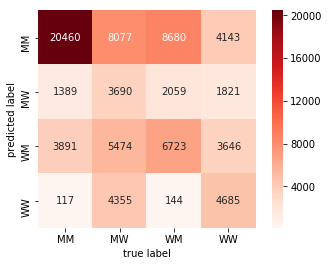

accuracy: 0.44809335383219495


In [29]:
# confusion matrix
mat = confusion_matrix(y_test, y_pred)

labels = sorted(set(y_test))

# plot it
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

# save
plt.savefig('images/predict_2genders_cm.png')

# show
plt.show()

print('accuracy:', accuracy_score(y_test, y_pred))

44.8% - this is not good! But it actually is a little better than our baseline (32.6%). It looks like the easiest to identify is male poster/male responder.

What if we just predict the gender they're responding to, and NOT try to also predict their own gender? Let's try to just predict the op_gender column.

In [30]:
# what is our baseline?
responder_df.op_gender.value_counts(normalize=True)

M    0.598184
W    0.401816
Name: op_gender, dtype: float64

So our baseline is around 59.8% here.

In [31]:
X = list(responder_df.response_text)
y = list(responder_df.op_gender)

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(len(y_train))
print(len(y_test))

317412
79354


In [32]:
# use same parameters
model = make_pipeline(TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2), tokenizer=nltk.word_tokenize),
                      MultinomialNB())

In [33]:
# fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

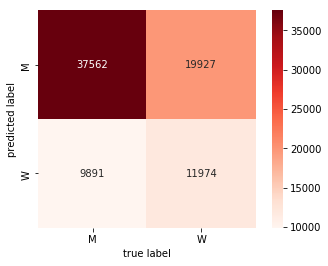

accuracy: 0.6242407440078634


In [34]:
# confusion matrix
mat = confusion_matrix(y_test, y_pred)

labels = sorted(set(y_test))

# plot it
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

# save
plt.savefig('images/predict_poster_cm.png')

# show
plt.show()

print('accuracy:', accuracy_score(y_test, y_pred))

62.4%... only a couple points higher than the baseline. This seems like a difficult task. I'd like to encorporate other features, but I am still very confused by how to use FeatureUnion.